# Quantum Advantage With Simulated Errors

In [1]:
## imports etc
import importlib, pkg_resources
importlib.reload(pkg_resources)
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import utils
import os
np.random.seed(1234)

2024-05-09 12:42:33.341647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:42:33.372254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:42:33.372416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:42:33.372941: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Data Preparation

In [2]:
N_TRAIN = 100
N_TEST = 20
DATASET_DIM = 3

x_train, x_test, y_train, y_test = utils.get_prepared_data(N_TRAIN, N_TEST, DATASET_DIM)

## Ideal Projected Quantum Kernel (PQK) Features

### Prepare Random Rotations

In [3]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
random_rots = utils.load_or_create_random_rots(DATASET_DIM + 1)

### Ideal Circuit And PQK Features

In [4]:
x_train_pqki, x_test_pqki = utils.load_or_create_ideal_features(qubits, x_train, x_test, random_rots)

### Adversarial Labeling $Y^{\text{adv}}$ Based on Ideal PQK Features

In [5]:
y_train_adv, y_test_adv = utils.load_or_create_adversarial_labels(x_train_pqki, x_test_pqki, x_train, x_test, qubits, N_TRAIN)

## Neural Networks

### Train multiple $\text{NN}_{\text{Qe}}$

In [30]:
n_models = 2
errors = [0.00001, 0.0001]
avg_err_histories = np.empty((0, 1000))
for error in errors:
    avg_history = np.zeros(1000)
    for i in range(n_models):
        avg_history += utils.load_or_train_model_history(qubits, error, i, x_train, x_test, y_train_adv, y_test_adv, random_rots)
    avg_history /= n_models
    avg_err_histories = np.append(avg_err_histories, [avg_history], axis=0)

### Ideal $\text{NN}_{\text{Qi}}$ and $\text{NN}_{\text{C}}$

In [15]:
__location__ = utils.get_file_location()
ideal_avg_history_path = os.path.join(__location__, f'model_histories_avg/N_TRAIN_{N_TRAIN}_N_TEST{N_TEST}_qn_{len(qubits)}_models_{n_models}_ideal_avg_history.npy')
try:
    ideal_avg_history = np.load(ideal_avg_history_path)
except:
    ideal_avg_history = np.zeros(1000)
    for i in range(n_models):
        ideal_avg_history += utils.create_and_train_pqk_model(qubits, x_train_pqki, y_train_adv, x_test_pqki, y_test_adv, N_TRAIN, N_TEST).history['val_accuracy']
    ideal_avg_history /= n_models
    np.save(ideal_avg_history_path, ideal_avg_history)

classical_avg_history_path = os.path.join(__location__, f'model_histories_avg/N_TRAIN_{N_TRAIN}_N_TEST{N_TEST}_qn_{len(qubits)}_models_{n_models}_classical_avg_history.npy')
try:
    classical_avg_history = np.load(classical_avg_history_path)
except:
    classical_avg_history = np.zeros(1000)
    for i in range(n_models):
        classical_avg_history += utils.create_and_train_fair_classical_model(x_train,y_train_adv, x_test, y_test_adv, DATASET_DIM).history['val_accuracy']
    classical_avg_history /= n_models
    np.save(classical_avg_history_path, classical_avg_history)

## Plot Training Histories

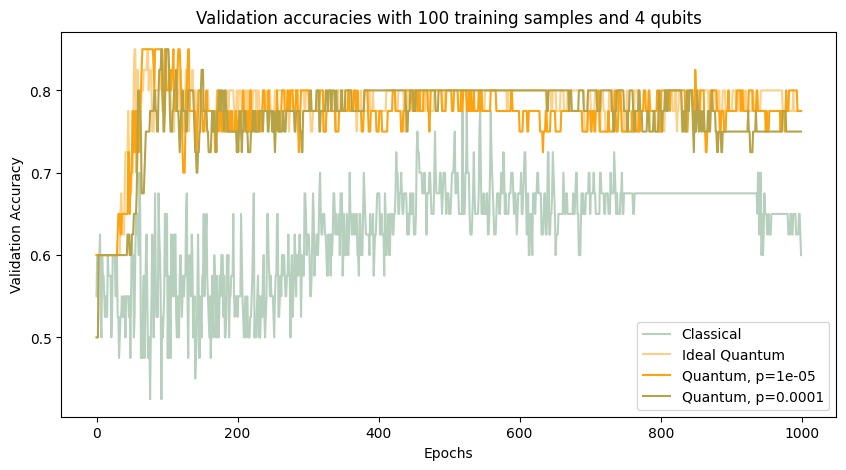

In [32]:
utils.plot_model_histories(classical_avg_history, ideal_avg_history, avg_err_histories, errors, N_TRAIN, len(qubits))